In [1]:
# Install catalax
# !pip install catalax

In [1]:
import json
import jax.numpy as jnp
import numpy as np

import catalax as ctx
import catalax.mcmc as cmc

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p2ga_pgm, k_p3ga_pgm, vf_pgm, keq_pgm, vf_eno, k_PEP_eno, keq_eno, k_p2ga_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno   0.50     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False          None     None        None   
4     keq_eno     keq_eno   6.70     False          None     None        None   
5     keq_pgm     keq_pgm   0.19     False          None     None        None   
6      vf_eno      vf_eno   1.35     False          None     None        None   
7      vf_pgm      vf_pgm   9.40     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

In [3]:
data = jnp.load("C:/Users/danic/OneDrive/Desktop/Kyle_Kamo_Data.npy")
time = jnp.load("C:/Users/danic/OneDrive/Desktop/Kyle_Kamo_Time.npy")
y0s = jnp.load("C:/Users/danic/OneDrive/Desktop/Kyle_Kamo_AllInitials.npy")
initial_conditions = json.load(open("C:/Users/danic/OneDrive/Desktop/model_kamo_kyle.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)


print(f"Time: {time.shape} | Data: {data.shape}")

Time: (29, 19) | Data: (29, 19, 3) | Initial Conditions: (29, 3)
(29, 19, 3)
(29, 19)
(29, 3)
Time: (29, 19) | Data: (29, 19, 3)


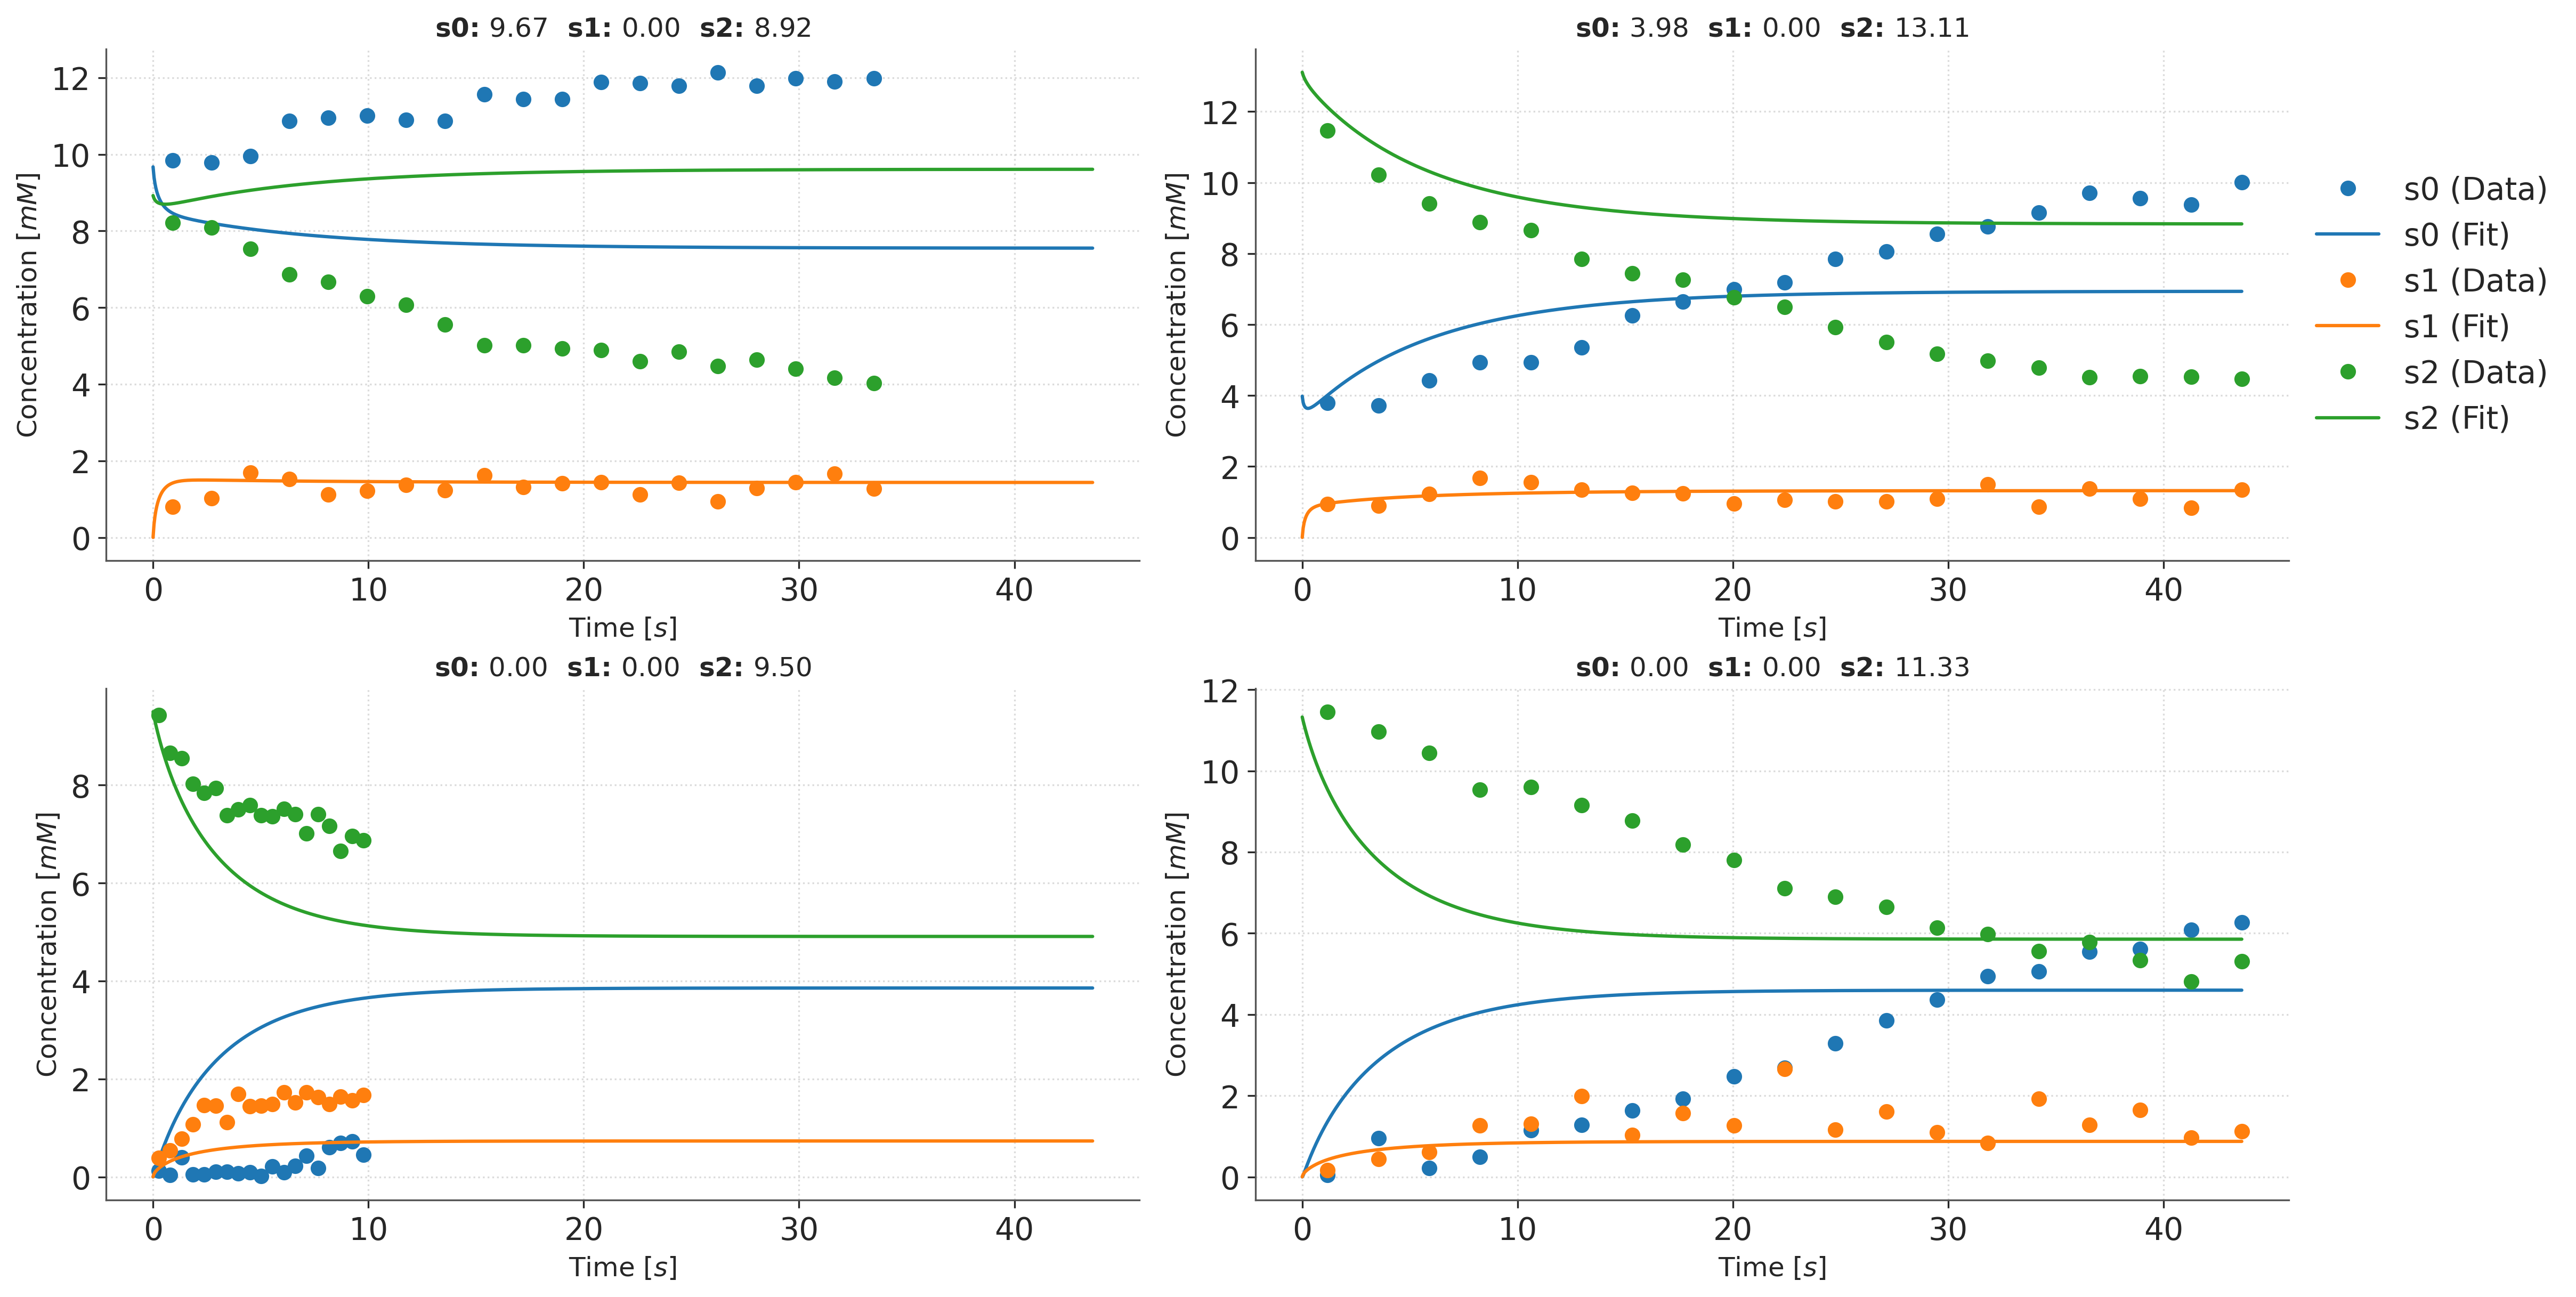

In [4]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
)

In [5]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-6, high=200.0)


# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [6]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=10000,
    dt0=0.1,
    max_steps=64**4
)

🔸 Priors
├── k_p2ga_pgm: U(low=1e-06, high=200.0)
├── k_p3ga_pgm: U(low=1e-06, high=200.0)
├── vf_pgm: U(low=1e-06, high=200.0)
├── keq_pgm: U(low=1e-06, high=200.0)
├── vf_eno: U(low=1e-06, high=200.0)
├── k_PEP_eno: U(low=1e-06, high=200.0)
├── keq_eno: U(low=1e-06, high=200.0)
├── k_p2ga_eno: U(low=1e-06, high=200.0)

🚀 Running MCMC



sample: 100%|███████████████████████| 11000/11000 [1:39:16<00:00,  1.85it/s, 27 steps of size 9.25e-02. acc. prob=0.80]




🎉 Finished

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   k_PEP_eno      0.56      0.37      0.49      0.04      1.10    258.48      1.01
  k_p2ga_eno     33.42     26.57     26.15      1.05     70.56    397.27      1.00
  k_p2ga_pgm      1.62      0.62      1.49      0.82      2.55    116.59      1.01
  k_p3ga_pgm    167.98     25.69    174.46    130.38    200.00   1484.31      1.00
     keq_eno      3.20      0.19      3.19      2.91      3.51   1615.42      1.00
     keq_pgm      0.12      0.01      0.12      0.11      0.13   1984.21      1.00
       sigma      1.20      0.02      1.20      1.16      1.23    273.27      1.01
      vf_eno    126.32     52.81    136.79     43.81    199.98     49.60      1.03
      vf_pgm      6.89      1.32      6.87      4.63      8.88    577.11      1.01

Number of divergences: 420


In [16]:
np.mean?

Signature:      
np.mean(
    a,
    axis=None,
    dtype=None,
    out=None,
    keepdims=<no value>,
    *,
    where=<no value>,
)
Call signature:  np.mean(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function mean at 0x000002767E7EEF20>
File:            c:\users\danic\anaconda3\envs\test\lib\site-packages\numpy\core\fromnumeric.py
Docstring:      
Compute the arithmetic mean along the specified axis.

Returns the average of the array elements.  The average is taken over
the flattened array by default, otherwise over the specified axis.
`float64` intermediate and return values are used for integer inputs.

Parameters
----------
a : array_like
    Array containing numbers whose mean is desired. If `a` is not an
    array, a conversion is attempted.
axis : None or int or tuple of ints, optional
    Axis or axes along which the means are computed. The default is to
    compute the mean of the flattened array.

    .. versionadded:: 1.7.0

    If this is 

In [7]:
mcmc

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\corner\core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\mcmc\plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


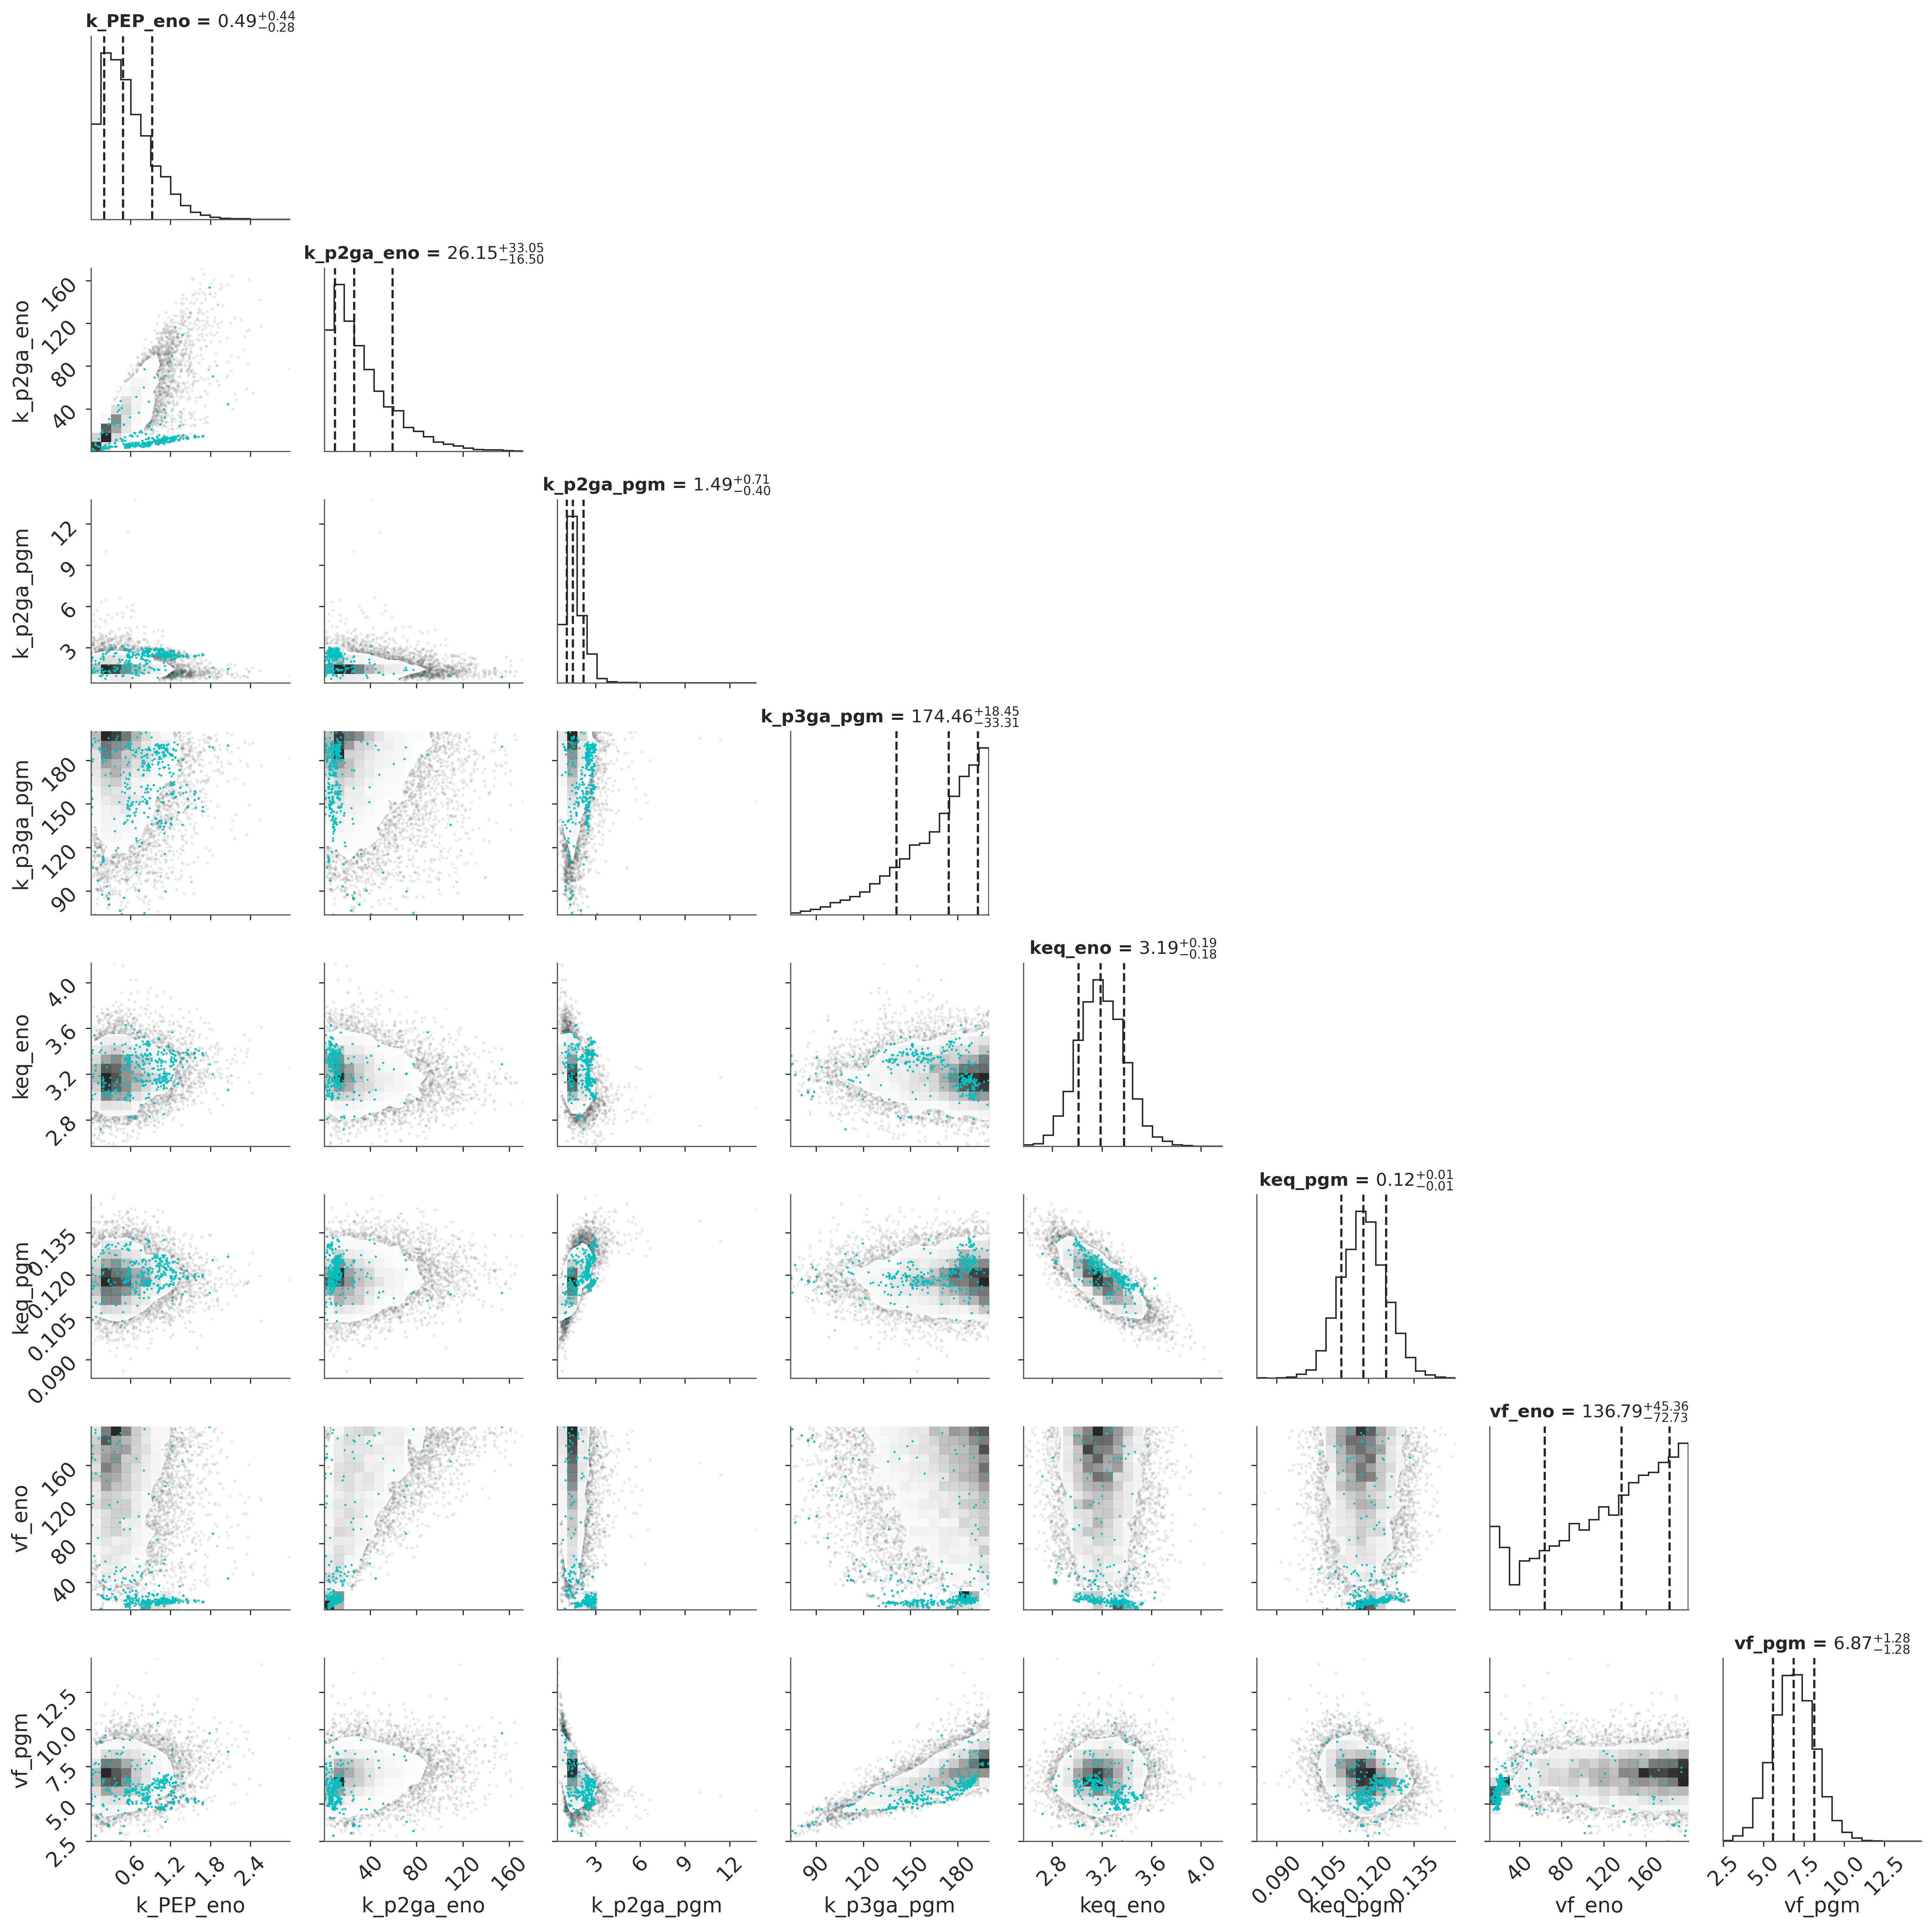

In [8]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\mcmc\plotting.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


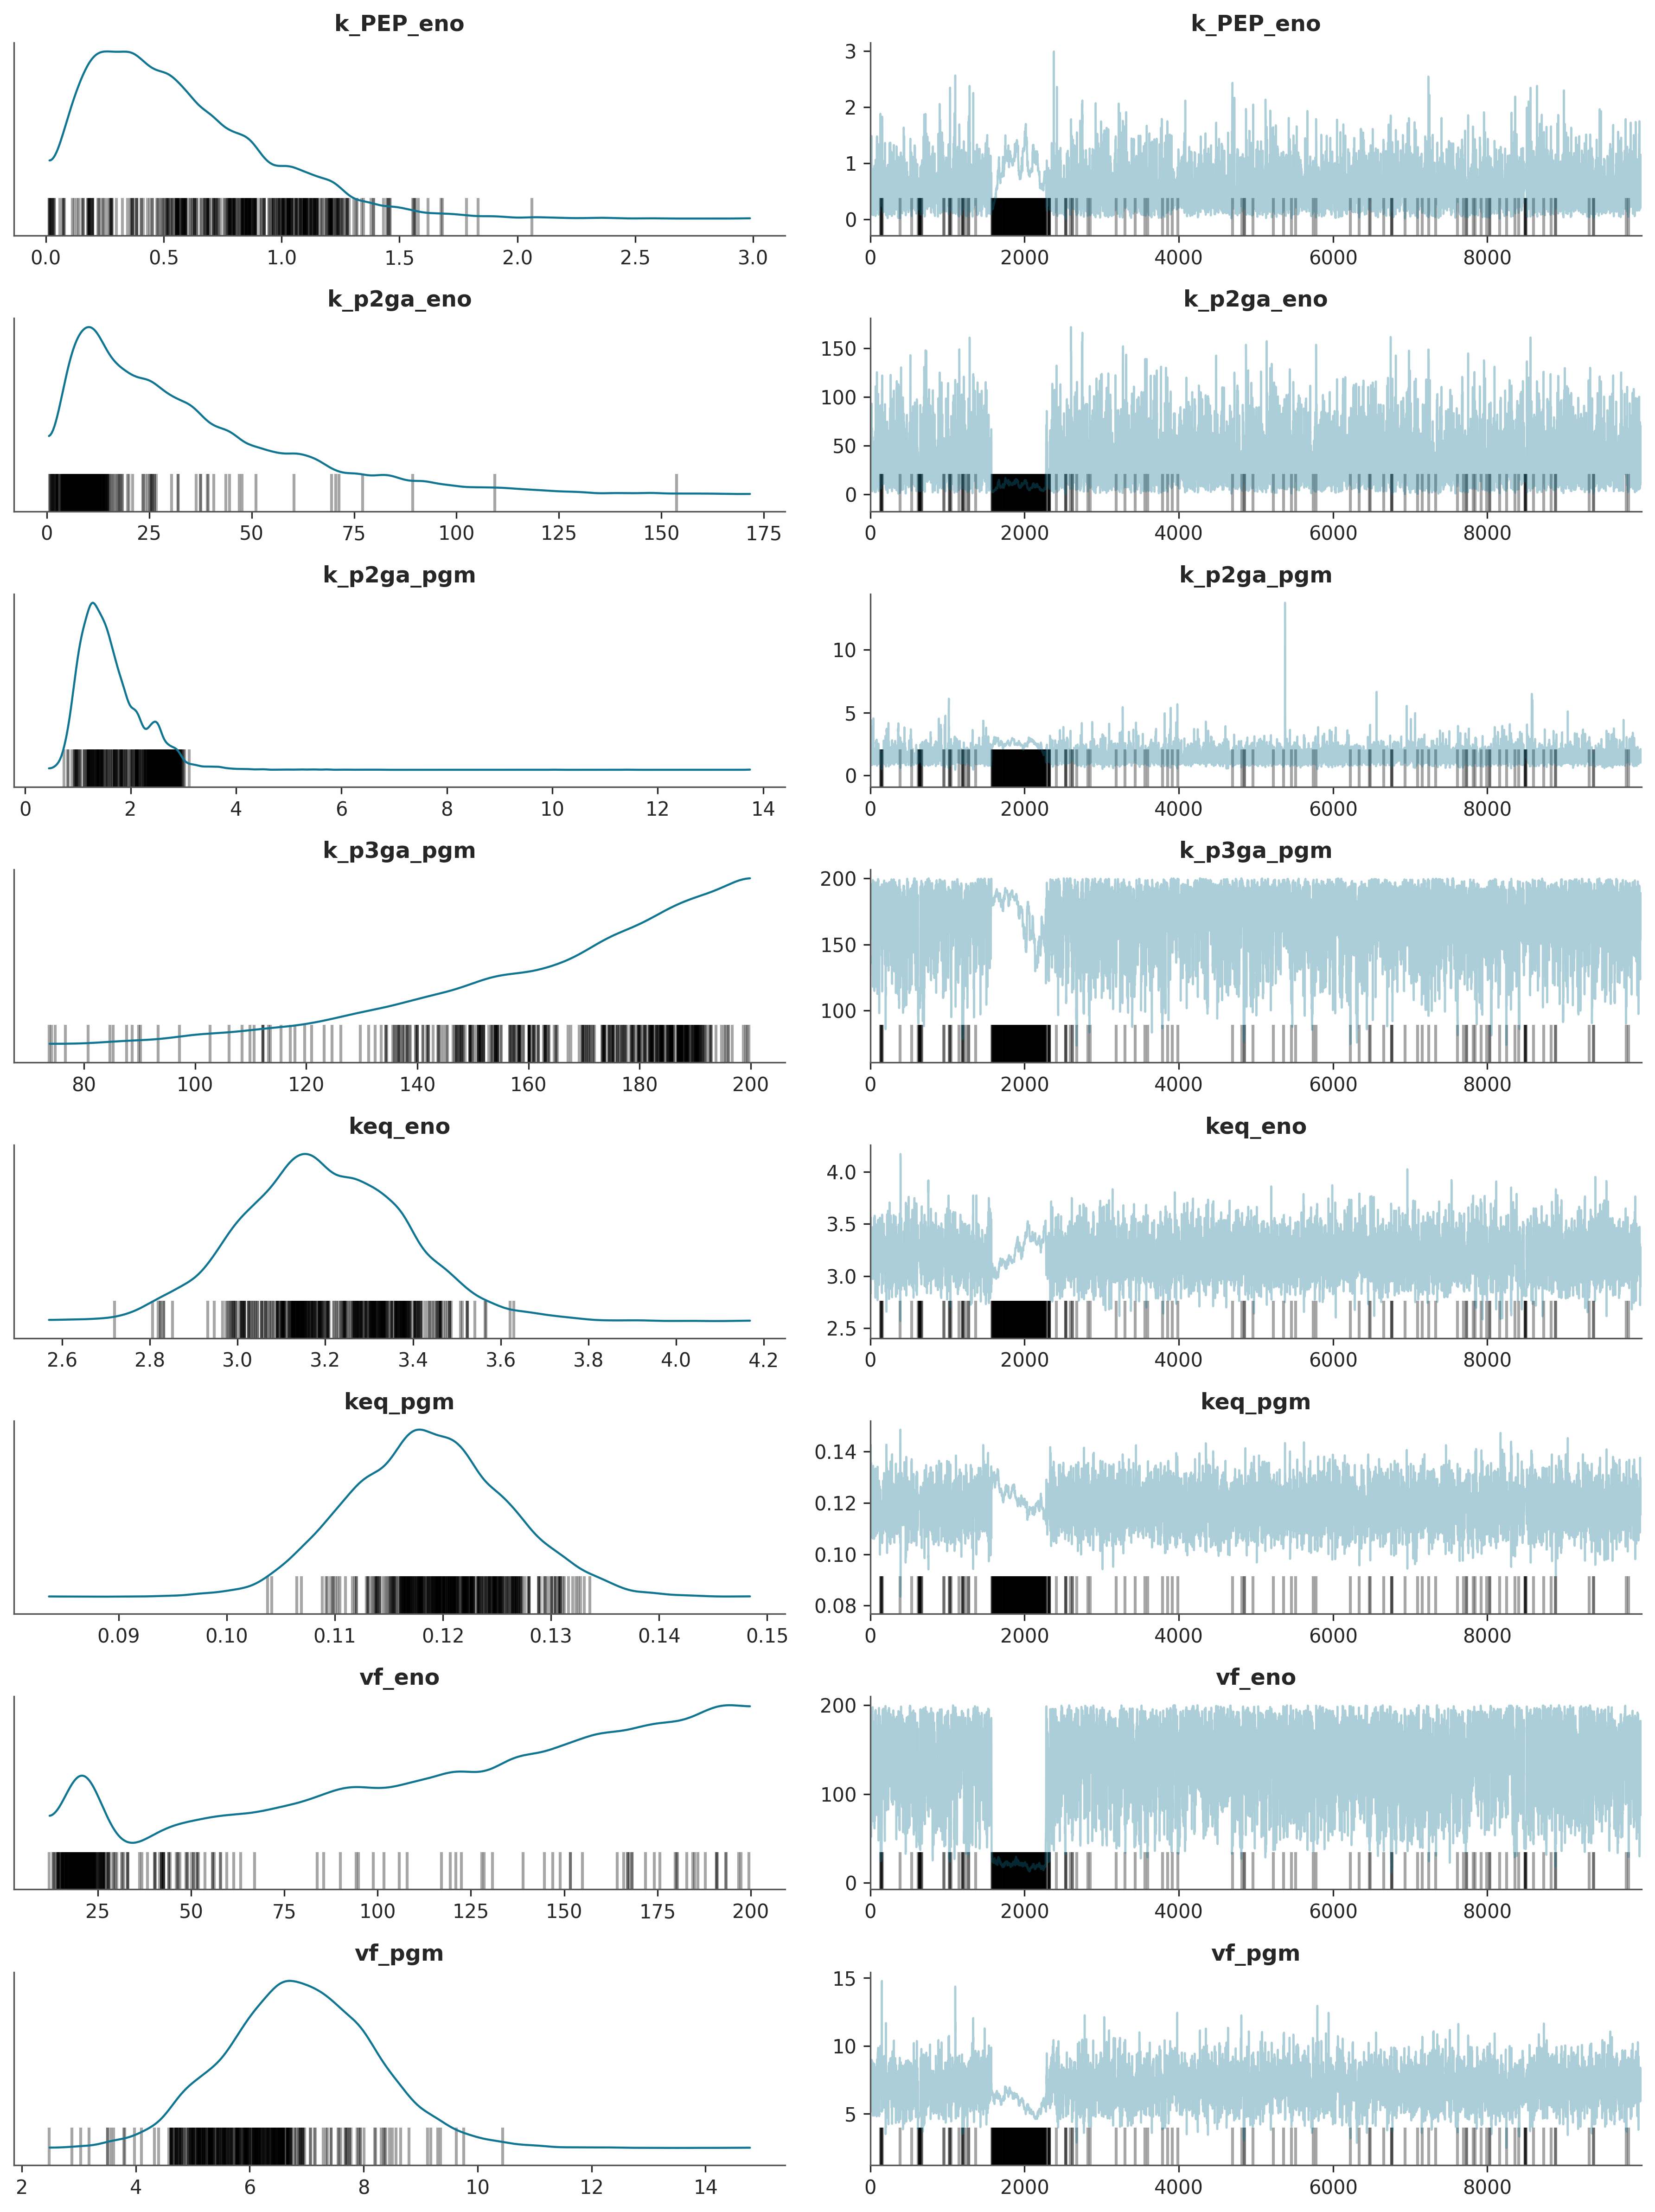

In [9]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

In [10]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

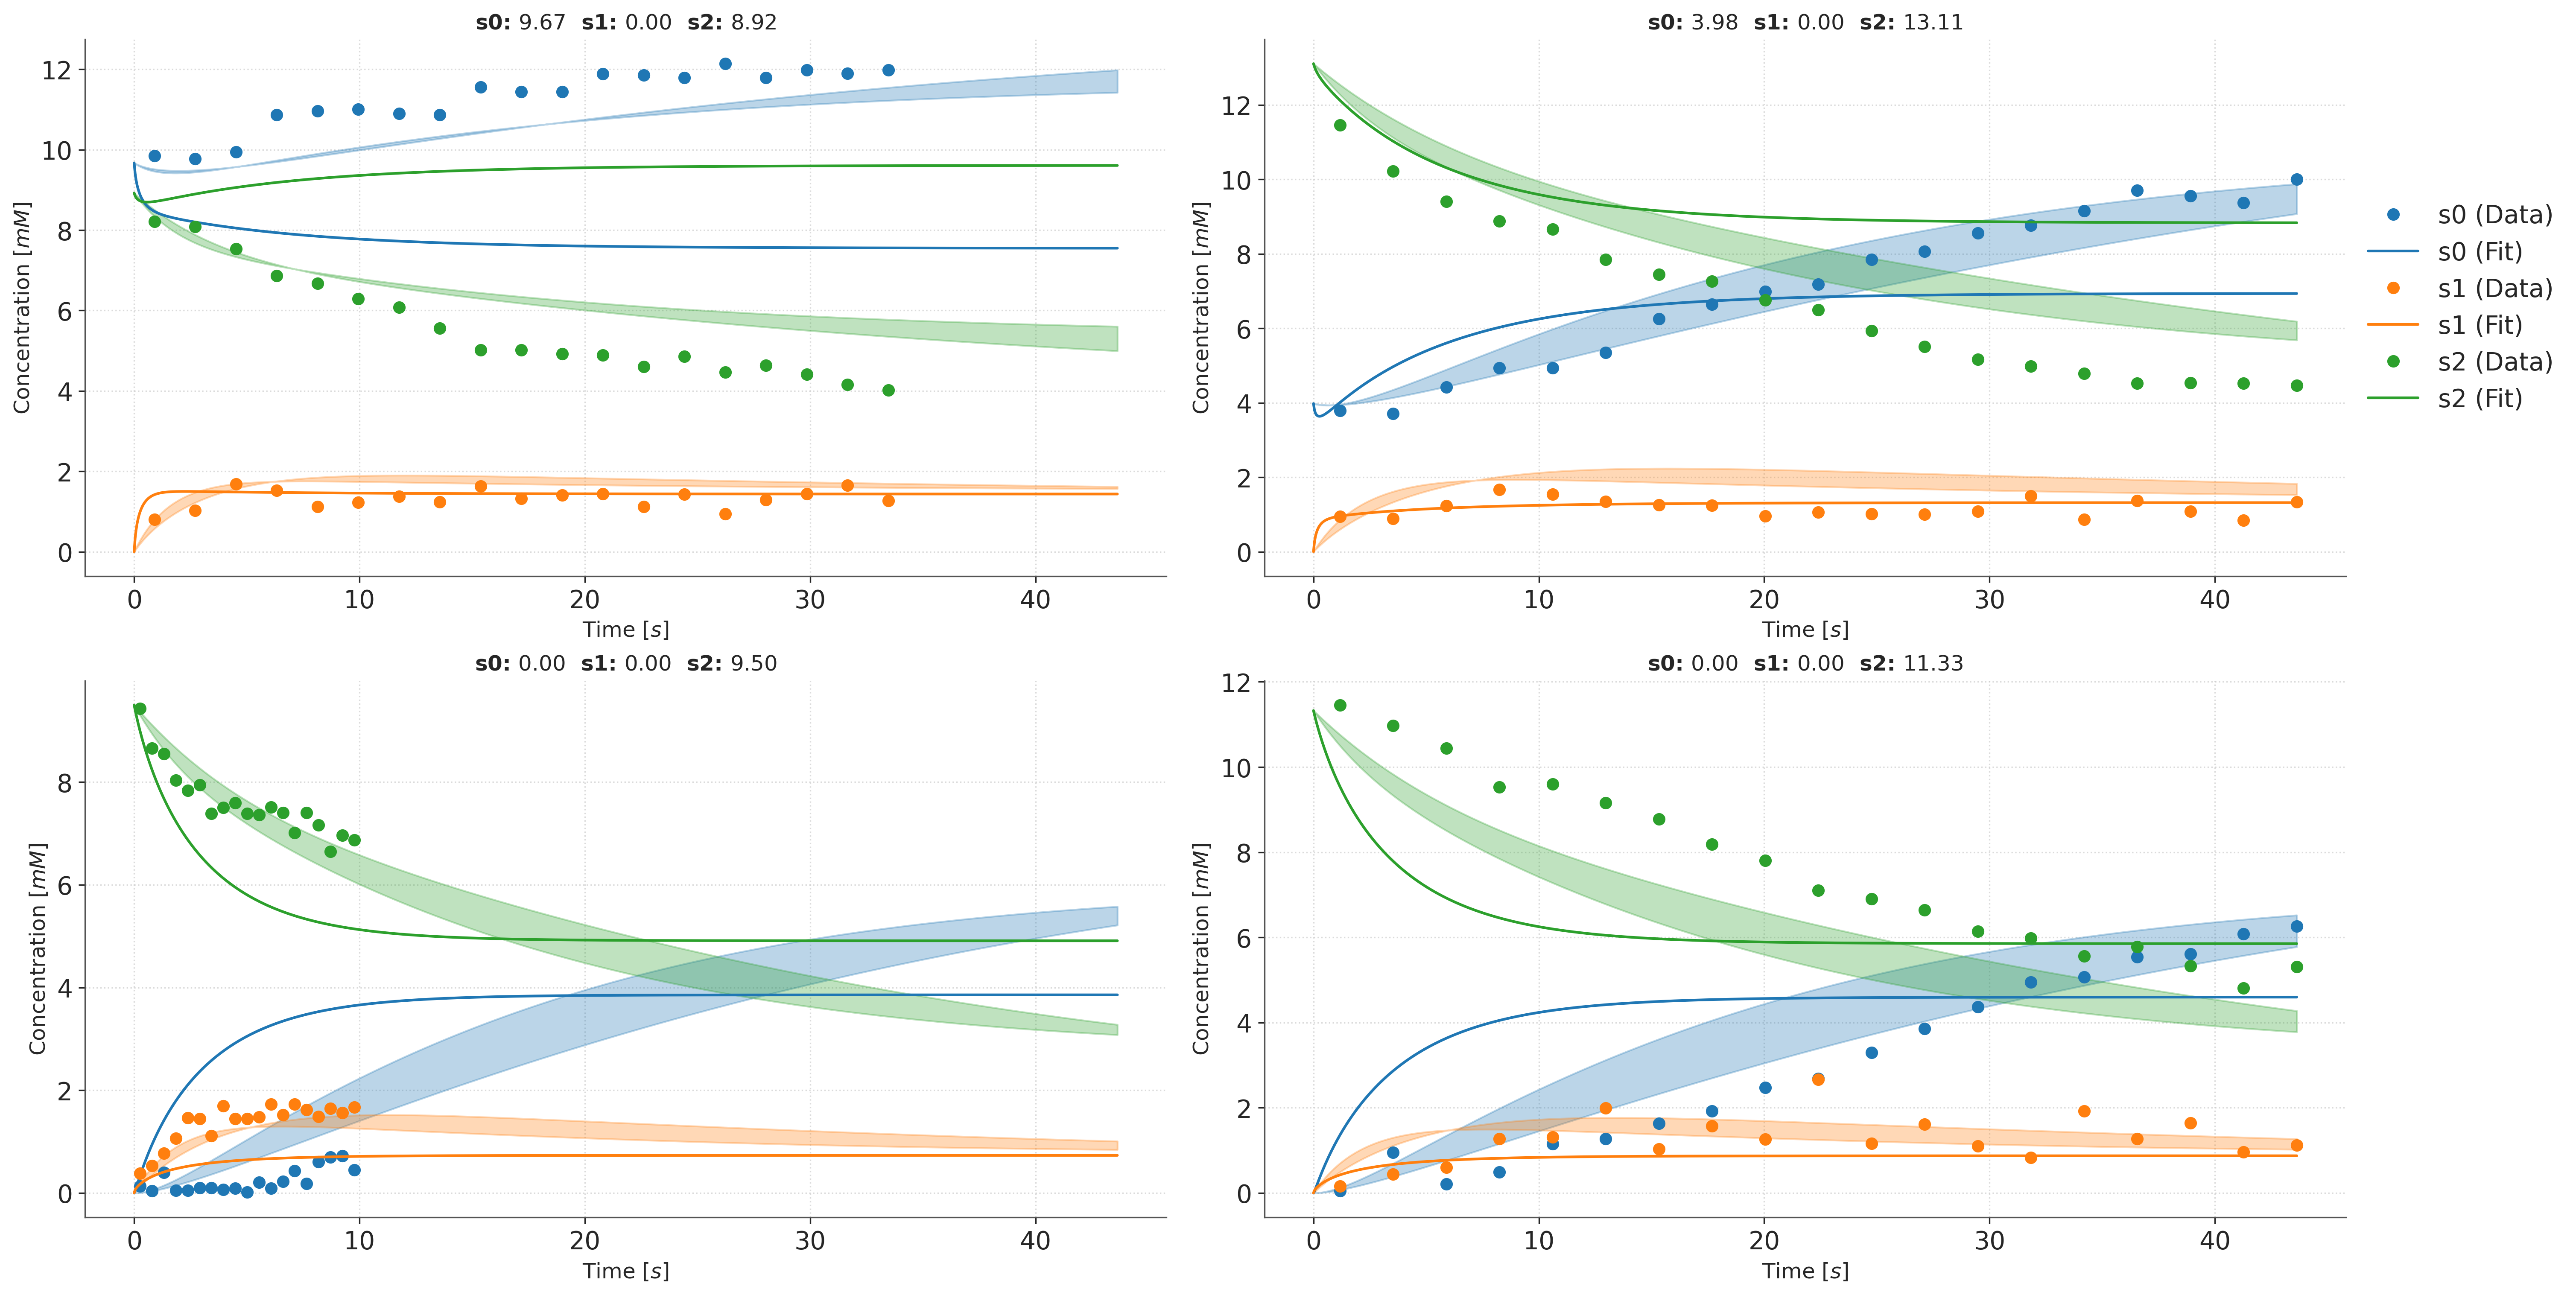

In [11]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       

#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(10,5),
    mcmc=mcmc
)